In [1]:
from datasets import Dataset, load_dataset, DatasetDict, ClassLabel, concatenate_datasets
import numpy as np
import torch
import pandas as pd

#Seeding for deterministic results i.e. showing same output 
RANDOM_SEED = 64
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
   torch.cuda.manual_seed(RANDOM_SEED)
   torch.cuda.manual_seed_all(RANDOM_SEED) 
   torch.backends.cudnn.deterministic = True  
   torch.backends.cudnn.benchmark = False

/home/njfernandez/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
emoevent_es_dataset = load_dataset("csv", sep = '\t', data_files ={'train': r'es_train.tsv',
                                                        'test': r'es_test.tsv',
                                                       'valid': r'es_dev.tsv'})
emoevent_en_dataset = load_dataset("csv", sep = '\t', data_files ={'train': r'en_train.tsv',
                                                        'test': r'en_test.tsv',
                                                       'valid': r'en_dev.tsv'})

train_dataset = concatenate_datasets([emoevent_es_dataset['train'], emoevent_en_dataset['train']])
valid_dataset = concatenate_datasets([emoevent_es_dataset['valid'], emoevent_en_dataset['valid']])
test_dataset = concatenate_datasets([emoevent_es_dataset['test'], emoevent_en_dataset['test']])

emoevent = DatasetDict({'train': train_dataset.shuffle(seed=42), 'valid': valid_dataset.shuffle(seed=42), 'test': test_dataset.shuffle(seed=42)})

Found cached dataset csv (/home/njfernandez/.cache/huggingface/datasets/csv/default-960b1f9335da6974/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)
100%|██████████| 3/3 [00:00<00:00, 938.18it/s]
Found cached dataset csv (/home/njfernandez/.cache/huggingface/datasets/csv/default-f0f3a67dac6080b1/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)
100%|██████████| 3/3 [00:00<00:00, 1037.85it/s]
Loading cached shuffled indices for dataset at /home/njfernandez/.cache/huggingface/datasets/csv/default-960b1f9335da6974/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-6625f3534539277f.arrow
Loading cached shuffled indices for dataset at /home/njfernandez/.cache/huggingface/datasets/csv/default-960b1f9335da6974/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-e7f493ef178ff284.arrow
Loading cached shuffled indices for dataset at /home/njfernandez/.cache/huggingface/datasets/csv/default-960b1f9335

In [3]:
comfunctions_basic = 'comfunct_basic.txt'
df = pd.read_csv(comfunctions_basic, delimiter=";")
df = df[df['function'].isin(['ANGRY', 'DISLIKE', 'OTHER', 'PESSIMISTIC', 'WORRIED'])]

df

,text,function
85,I'm not really very keen on it,DISLIKE
86,I'm not really very keen,DISLIKE
87,I'm not really keen on it,DISLIKE
88,I'm not really keen,DISLIKE
89,I'm not very keen on it,DISLIKE
...,...,...
897,you could do it,OTHER
898,you look nice,OTHER
899,you look smart,OTHER
900,you're right,OTHER


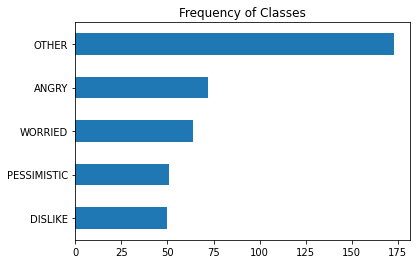

In [4]:
import matplotlib.pyplot as plt

df["function"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.rcParams['figure.figsize'] = [10, 80]
plt.show()

In [5]:
function_mapping = {'OTHER': ['others', 'surprise', 'joy'],
           'NOT_INTERESTED': [''], 
           'DISLIKE':['disgust'], 
           'NOT_CORRECT': [''], 
           'PESSIMISTIC':['sadness'], 
           'WORRIED':['fear'], 
           'ANGRY': ['anger'], 
           'DISAPPOINTED': [''], 
           'BORED': [''], 
           'NOT_APPROVE':[''], 
           'NOT_IMPORTANT': [''], 
           'DISAGREE': [''], 
           'WARN': [''], 
           'COMPLAIN': [''], 
           'THREATEN': [''], 
           'UNWILLING': [''], 
           'DISTRUST' : [''],
           'REFUSE': [''] }

emoevent = emoevent.remove_columns("id").remove_columns("event").remove_columns("offensive").rename_column('tweet', 'text')
def map_labels(batch):
    batch['function'] = [[] for _ in range(len(batch['text']))]
    for i, item in enumerate(batch["function"]):
        for key, value in function_mapping.items():
            for emotion in value:
                if emotion == batch["emotion"][i]:
                    batch["function"][i] = key
                    break
    return batch
emoevent = emoevent.map(map_labels, batched=True)

Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/csv/default-960b1f9335da6974/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-3ab4890ed31942b1.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/csv/default-960b1f9335da6974/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-914966b29f99b887.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/csv/default-960b1f9335da6974/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-0b09035e82acf021.arrow


In [6]:
dataset = DatasetDict({
    "train": Dataset.from_pandas(df.reset_index(drop=True)).shuffle(seed=42),
    "valid": emoevent['valid'],
    "test": emoevent['test']
}
    )
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'function'],
        num_rows: 410
    })
    valid: Dataset({
        features: ['text', 'emotion', 'function'],
        num_rows: 1588
    })
    test: Dataset({
        features: ['text', 'emotion', 'function'],
        num_rows: 3073
    })
})

In [7]:
dataset['train'][0]

{'text': "I'm annoyed with it", 'function': 'ANGRY'}

In [8]:
dataset = dataset.class_encode_column("function")
labels = dataset['train'].features['function']
dataset = dataset.rename_column("function", "label")
print(labels.names)

Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/csv/default-960b1f9335da6974/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-74afeb9eca83f32d.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/csv/default-960b1f9335da6974/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-d6030169ed3c8735.arrow


['ANGRY', 'DISLIKE', 'OTHER', 'PESSIMISTIC', 'WORRIED']


In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding

transformer_model = 'cardiffnlp/twitter-xlm-roberta-base'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = (AutoModelForSequenceClassification
         .from_pretrained(transformer_model, num_labels = len(labels.names))).to(device)
tokenizer=AutoTokenizer.from_pretrained(transformer_model)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True,max_length=512)

ds_enc = dataset.map(tokenize, batched=True, batch_size=None)
data_collator = DataCollatorWithPadding(tokenizer, padding="longest")
ds_enc

Some weights of the model checkpoint at cardiffnlp/twitter-xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base and are newly initialized: ['classifier.den

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 410
    })
    valid: Dataset({
        features: ['text', 'emotion', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1588
    })
    test: Dataset({
        features: ['text', 'emotion', 'label', 'input_ids', 'attention_mask'],
        num_rows: 3073
    })
})

In [10]:
from sklearn.metrics import precision_recall_fscore_support
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [11]:
from transformers import TrainingArguments, Trainer

batch_size = 16
model_name = "functions_basic_finetuning"
training_args = TrainingArguments(
        output_dir=model_name,
        num_train_epochs=5,
        learning_rate = 2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_ratio=0.1,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        metric_for_best_model = "f1",
        load_best_model_at_end=True,
        save_total_limit = 1,        
        report_to='none',
    )

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=ds_enc["train"],
                  eval_dataset=ds_enc["valid"],                    
                  tokenizer=tokenizer,
                  data_collator=data_collator,)
trainer.train()

The following columns in the training set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
/home/njfernandez/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 410
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 65
  Number of trainable parameters = 278047493
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,1.364621,0.151008,0.200000,0.172085
2,No log,1.131046,0.245934,0.219966,0.207093
3,No log,1.291576,0.395495,0.280736,0.203357
4,No log,1.289798,0.294837,0.277097,0.196634
5,No log,1.313764,0.327940,0.280890,0.202558


The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: text, emotion. If text, emotion are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1588
  Batch size = 32
Saving model checkpoint to functions_basic_finetuning/checkpoint-13
Configuration saved in functions_basic_finetuning/checkpoint-13/config.json
Model weights saved in functions_basic_finetuning/checkpoint-13/pytorch_model.bin
tokenizer config file saved in functions_basic_finetuning/checkpoint-13/tokenizer_config.json
Special tokens file saved in functions_basic_finetuning/checkpoint-13/special_tokens_map.json
Deleting older checkpoint [functions_basic_finetuning/checkpoint-26] due to args.save_total_limit
/home/njfernandez/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along d

TrainOutput(global_step=65, training_loss=1.086111567570613, metrics={'train_runtime': 96.8229, 'train_samples_per_second': 21.173, 'train_steps_per_second': 0.671, 'total_flos': 15802505626500.0, 'train_loss': 1.086111567570613, 'epoch': 5.0})

In [12]:
preds_output = trainer.predict(ds_enc['test'])
print(preds_output.metrics)

The following columns in the test set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: text, emotion. If text, emotion are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 3073
  Batch size = 32
/home/njfernandez/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 1.1559010744094849, 'test_precision': 0.17388791281542026, 'test_recall': 0.2016365129250545, 'test_f1': 0.17884072943094864, 'test_runtime': 33.6365, 'test_samples_per_second': 91.359, 'test_steps_per_second': 2.884}


In [13]:
from sklearn.metrics import classification_report

y_true = np.array(ds_enc['test']["label"])
y_pred = preds_output.predictions.argmax(-1)

report = classification_report(
  y_true,
  y_pred,
  target_names=labels.names,
  zero_division=0
)
print(report)

              precision    recall  f1-score   support

       ANGRY       0.12      0.02      0.04       244
     DISLIKE       0.00      0.00      0.00       184
       OTHER       0.75      0.98      0.85      2316
 PESSIMISTIC       0.00      0.00      0.00       278
     WORRIED       0.00      0.00      0.00        51

    accuracy                           0.74      3073
   macro avg       0.17      0.20      0.18      3073
weighted avg       0.58      0.74      0.65      3073



In [14]:
report = classification_report(
  y_true,
  y_pred,
  target_names=labels.names,
  zero_division=0,
    output_dict=True
)

df = pd.DataFrame(report).transpose()
with open(r'classification_report_functions_basic_emoevent_finetuning.csv', 'w') as csv_file:
    df.to_csv(path_or_buf=csv_file)

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):    
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(50, 50))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)  
    font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 16}
    plt.rc('font', **font)
    ax.tick_params(axis='x', which='major', labelsize=15)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

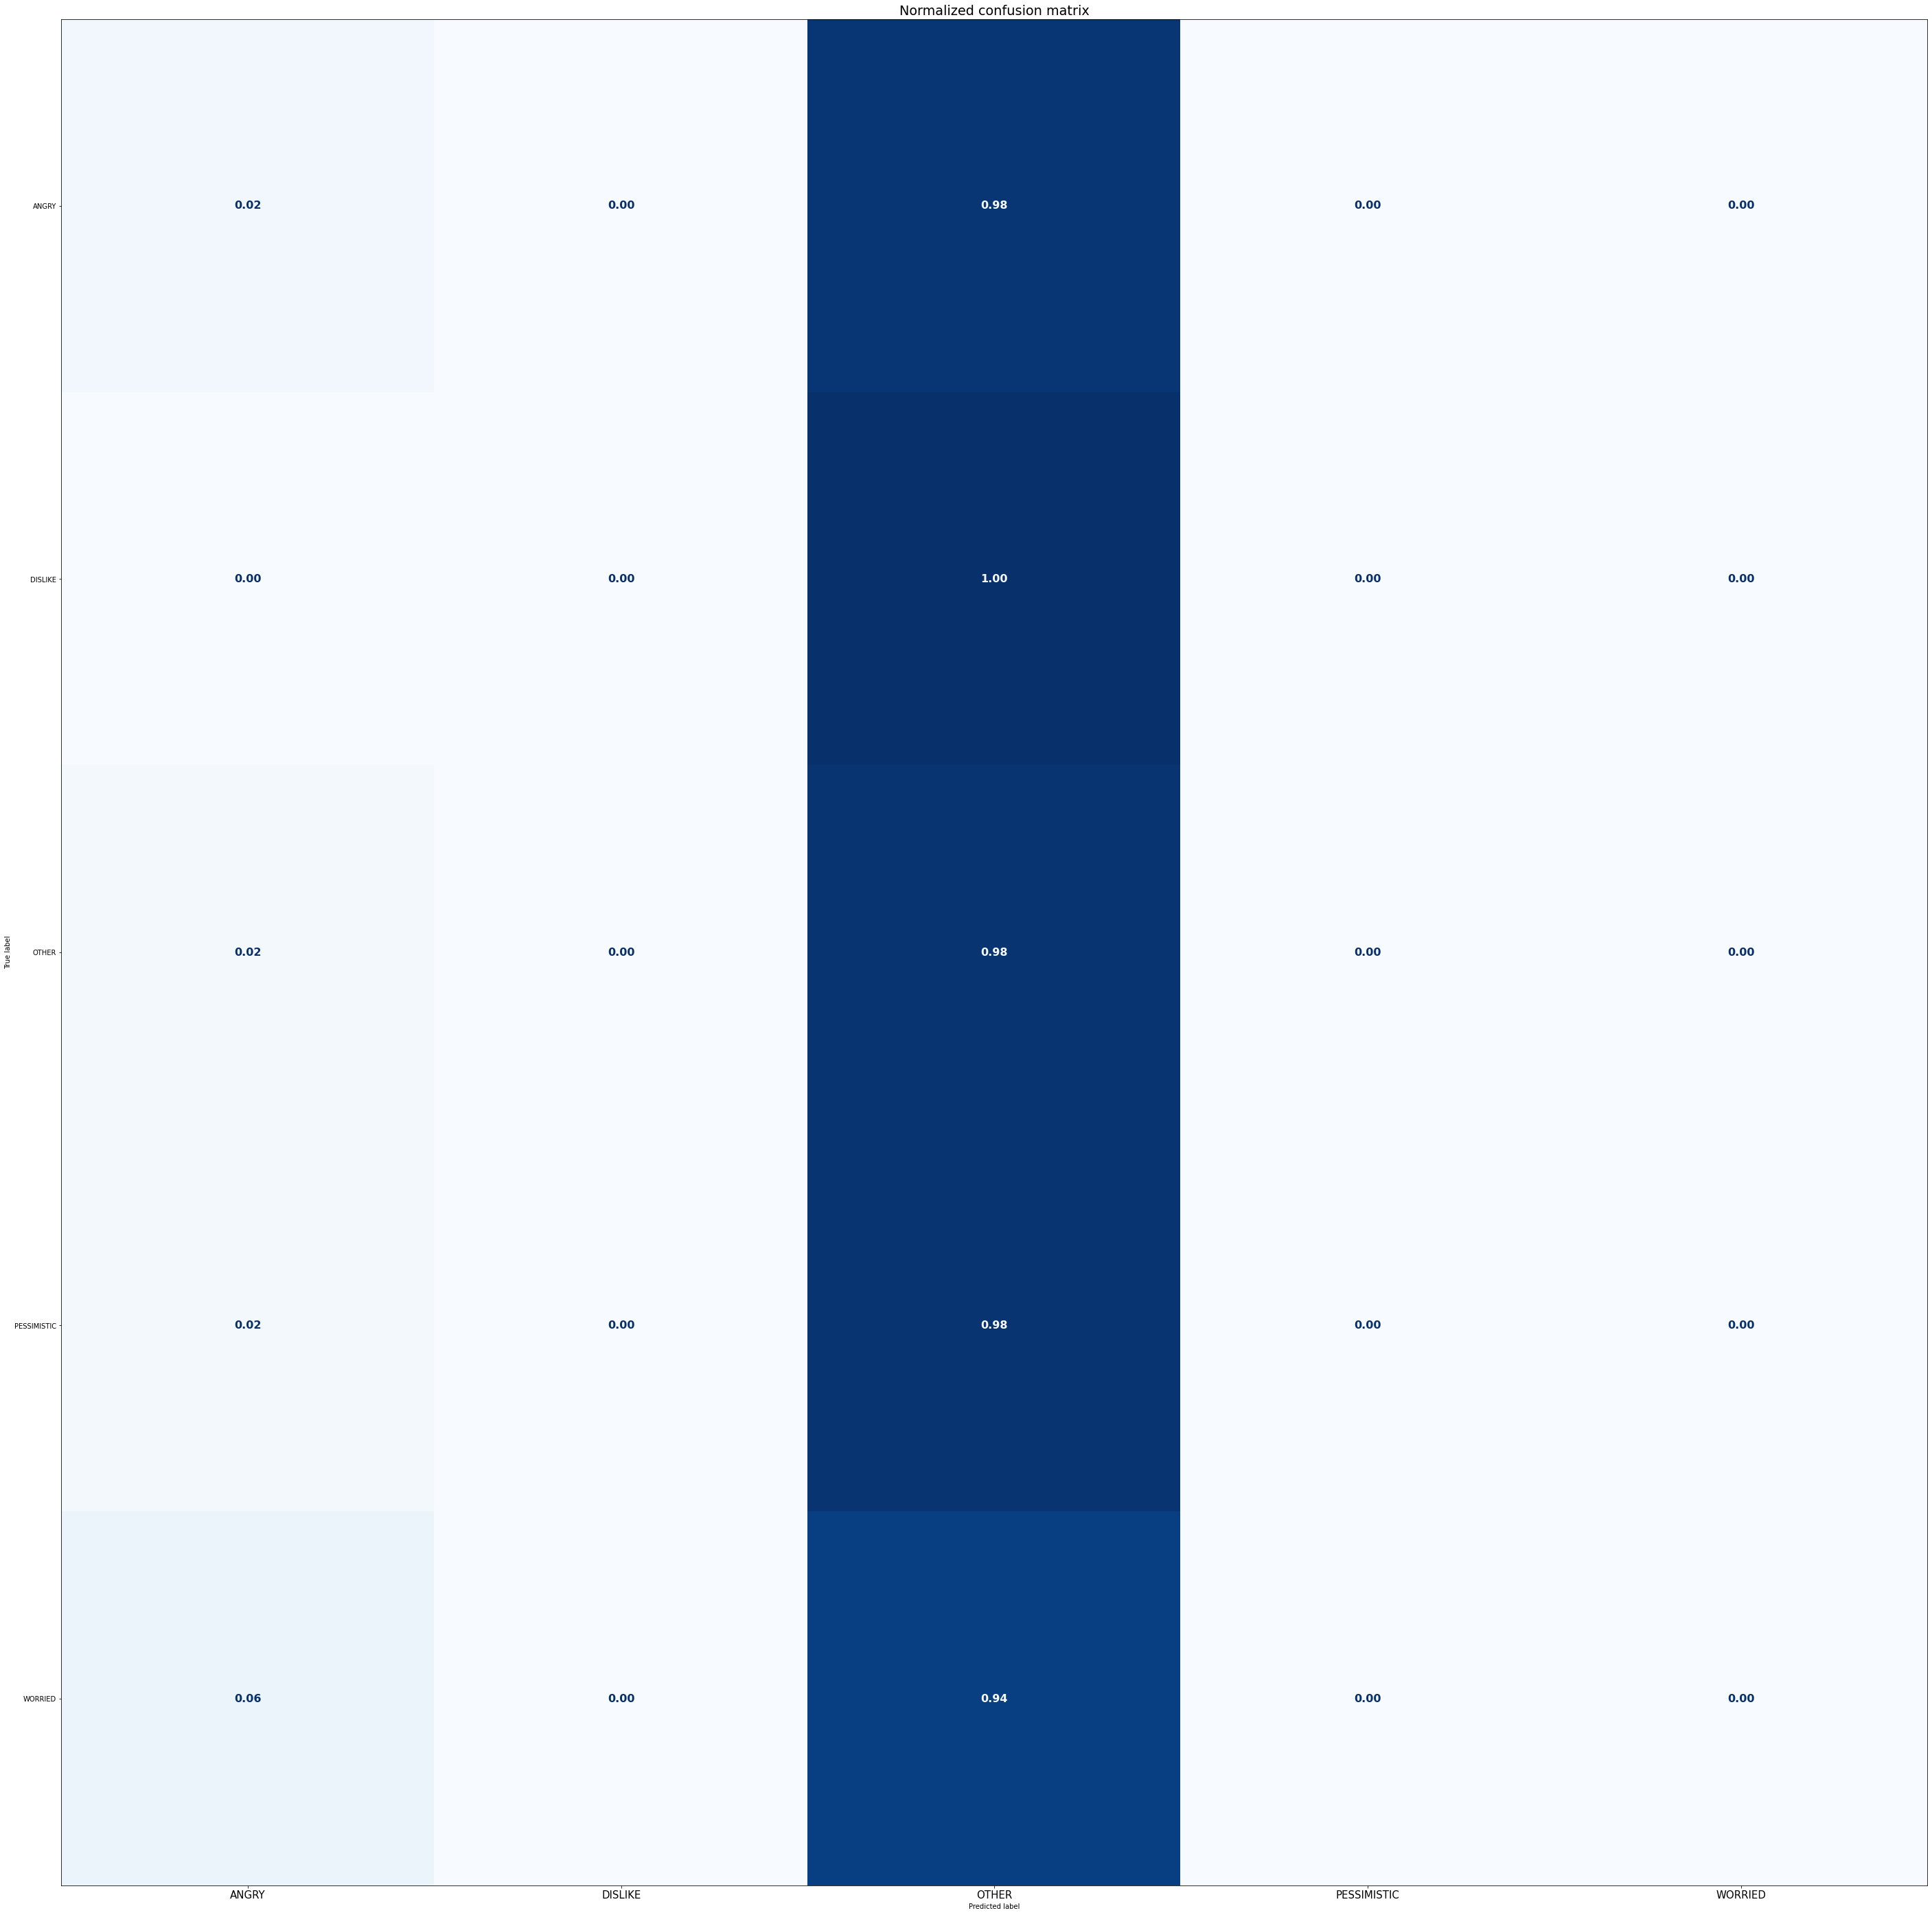

In [16]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(ds_enc["test"]["label"])
plot_confusion_matrix(y_preds, y_valid, labels.names)

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")     
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

ds_enc.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
ds_enc["test"] = ds_enc["test"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:  96%|█████████▋| 2960/3073 [00:45<00:01, 64.83 examples/s]

In [ ]:
def label_int2str(row):
    return dataset["train"].features["label"].int2str(row)

In [ ]:
ds_enc.set_format("pandas")
cols = ["tweet", 'emotion', "label", "predicted_label", "loss"]
df_test = ds_enc["test"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [ ]:
loss_values = df_test.sort_values("loss", ascending=False).head(50)
loss_values

In [ ]:
loss_values.to_csv('loss_values_functions_basic_emoevent_finetuning.tsv',header =True, sep = '\t',index=False)
df_test.to_csv('preds_functions_basic_emoevent_finetuning.tsv',header =True, sep = '\t',index=False)